# Solution Graded exercise: Modeling neurons

Exponential decay constant of EPSPs: 8.833481
Exponential decay constant of EPSPs: 3.713659
Exponential decay constant of EPSPs: 2.683203
Exponential decay constant of EPSPs: 2.158200
Exponential decay constant of EPSPs: 1.828944
Exponential decay constant of EPSPs: 1.600870
Exponential decay constant of EPSPs: 1.433273
Exponential decay constant of EPSPs: 1.304396
Exponential decay constant of EPSPs: 1.201772
Exponential decay constant of EPSPs: 1.117786
Exponential decay constant of EPSPs: 1.047838
Exponential decay constant of EPSPs: 0.988146
Exponential decay constant of EPSPs: 0.936418
Exponential decay constant of EPSPs: 0.890475
Exponential decay constant of EPSPs: 0.849865
Exponential decay constant of EPSPs: 0.813195
Exponential decay constant of EPSPs: 0.779628
Exponential decay constant of EPSPs: 0.748761
Exponential decay constant of EPSPs: 0.720902
Exponential decay constant of EPSPs: 0.693803


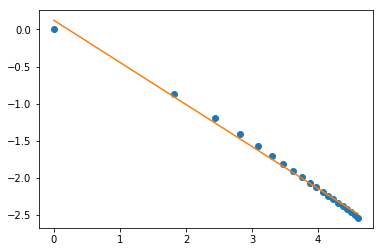

Linear slope: -0.568625


In [5]:
# Init
import neuron
import numpy
import matplotlib.pyplot as plt

neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

# Define soma
soma = neuron.h.Section(name='soma')
soma.L = 40
soma.diam = 40
soma.insert('hh');
soma.gl_hh = 5e-4 # Leak conductance, S/cm^2
soma.el_hh = -65 # Reversal potential leak current, mV
soma.gkbar_hh = 0.0 # in S/cm^2
soma.gnabar_hh = 0.0

# Define dendrite
dend = neuron.h.Section(name='dend')
dend.connect(soma, 0)
dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2
dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0
dend.L = 400 # micron
dend.diam = 1.0 # micron
dend.nseg = 51 # number of segments in the dendritic section
dend.Ra = 200

# Record voltage
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(dend(0)._ref_v);

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()

voltage_dist = {}
edcs = []

dend_diam_range = numpy.linspace(.1, 10.0, 20)

for dend_diam in dend_diam_range:
    dend.diam = dend_diam
    # Take distance from 25% -> 75% of dendrite to avoid boundary effects
    distance_range = numpy.linspace(0.25, .75, 10)

    # Add synapse 
    for syn_location in distance_range:
        expsyn = neuron.h.ExpSyn(syn_location, sec=dend) 

        netstim = neuron.h.NetStim()
        netstim.interval = 1
        netstim.number = 1
        netstim.start = 20
        netstim.noise = 0

        netcon = neuron.h.NetCon(netstim, expsyn)
        netcon.weight[0] = .01
        neuron.h.tstop = 100
        neuron.h.run()

        voltage_dist[syn_location] = numpy.array(voltage)

    # Store the EPSP sizes
    epsp_size = []
    for distance in distance_range:
        # Get the EPSP size by subtracting the min (baseline) voltage from the max voltage
        epsp_size.append(max(voltage_dist[distance])-min(voltage_dist[distance]))


    # Bring x[0] to 0.0
    x = distance_range-distance_range[0]

    # Normalize
    y = epsp_size/epsp_size[0]

    # Fit a linear line to log plot
    a, b = numpy.polyfit(x, numpy.log(y), 1)

    exp_decay_constant = -a
    
    edcs.append(exp_decay_constant)

    print('Exponential decay constant of EPSPs: %f' % exp_decay_constant)

x_diam = numpy.log(dend_diam_range/dend_diam_range[0])
y_diam = numpy.log(edcs/edcs[0])
plt.plot(x_diam, y_diam, 'o')
a_diam, b_diam = numpy.polyfit(x_diam, y_diam, 1)
plt.plot(x_diam, a_diam*x_diam + b_diam)
plt.show()

print('Linear slope: %f' % a_diam)
